<p style='font-size:1.75rem;line-height:1.5'>
    Features: Temperature, Received Signal Strength Indication (RSSI) <br> Train accuracy:  62.96 % <br> Test accuracy:  59.46 %
    </p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import *
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("../Zeng_Eloise_CollectedData/pi_pact_data.csv")
data.insert(0, 'ones', 1)
X = data[['ones', 'temperature', 'RSSI']]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = np.reshape(y_train.to_numpy(), (len(y_train),1))
y_test = np.reshape(y_test.to_numpy(), (len(y_test),1))
M = data.shape[0]
m = X_train.shape[0]

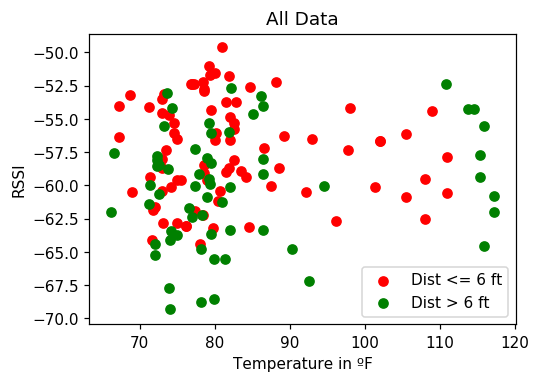

In [3]:
pos = data.loc[data.tctl == 1].index.values
neg = data.loc[data.tctl == 0].index.values
plt.figure(figsize=(5, 3.5), dpi=110)
plt.scatter(data.temperature[pos], data.RSSI[pos], color='r', label='Dist <= 6 ft')
plt.scatter(data.temperature[neg], data.RSSI[neg], color='g',label='Dist > 6 ft')
plt.xlabel('Temperature in ºF')
plt.ylabel('RSSI')
plt.title('All Data')
plt.legend()
plt.show()

## Sigmoid, gradient, and cost function <br> Use scipy.optimize to do logistic regression on training data.

In [4]:
import scipy.optimize as op

def sigmoid(z):
    z = np.ones(z.shape) / (1 + np.exp(-z))
    return z

def Gradient(theta,x,y):
    m,n = x.shape
    theta = theta.reshape((n,1)) 
    y = y.reshape((m,1))
    sigmoid_x_theta = sigmoid(x.dot(theta)) 
    grad = ((x.T).dot(sigmoid_x_theta-y))/m 
    return grad.flatten() 

def CostFunc(theta,x,y):
    m,n = x.shape  
    theta = theta.reshape((n,1)) 
    y = y.reshape((m,1)) 
    term1 = np.log(sigmoid(x.dot(theta))) 
    term2 = np.log(1-sigmoid(x.dot(theta))) 
    term1 = term1.reshape((m,1))
    term2 = term2.reshape((m,1))
    term = y * term1 + (1 - y) * term2 
    J = -((np.sum(term))/m) 
    return J 

m, n = X_train.shape
initial_theta = np.zeros((n, 1))
Result = op.minimize(fun = CostFunc, 
                     x0 = initial_theta, 
                     args = (X_train, y_train),
                     method = 'TNC',
                     jac = Gradient) 

theta = Result.x # optimal theta
Result

     fun: 0.6077458206963252
     jac: array([-4.18984095e-05, -1.70969996e-04,  3.89878834e-04])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 25
     nit: 12
  status: 1
 success: True
       x: array([14.36824805, -0.02039683,  0.21092071])

In [5]:
# Predicts if Pis were TCTL using x's features and theta
def predict(x):
    predict = sigmoid(np.dot(x, theta))
    predict[predict >= 0.5] = 1
    predict[predict < 0.5] = 0
    return predict

In [6]:
# Concatenate predictions on X_test and y_test
pred_y_test = np.concatenate([np.reshape(predict(X_test), (len(y_test), 1)), y_test], axis=1)
# Calculate accuracy (# of correct predictions / # of cases)
acc_test = round((np.ravel(sum(pred_y_test[:, 0] == pred_y_test[:, 1])/len(y_test))[0]) * 100, 2)
# Concatenate predictions on X_train and y_train
pred_y_train = np.concatenate([np.reshape(predict(X_train), (len(y_train), 1)), y_train], axis=1)
# Calculate accuracy (# of correct predictions / # of cases)
acc_train = round((np.ravel(sum(pred_y_train[:, 0] == pred_y_train[:, 1])/len(y_train))[0] * 100), 2)
print("Train accuracy: ", acc_train, "%")
print("Test accuracy: ", acc_test, "%")
percent_pos_train = round((sum(sum(y_train)) / len(y_train)) * 100) # % of cases are positive in training data
percent_pos_test = round((sum(sum(y_test)) / len(y_test)) * 100) # % of cases are positive in testing data
print(percent_pos_train, "% of cases are positive in training data")
print(percent_pos_test, "% of cases are positive in testing data")

Train accuracy:  62.96 %
Test accuracy:  59.46 %
57 % of cases are positive in training data
57 % of cases are positive in testing data


In [7]:
pos_indice = np.nonzero(pred_y_train[:, 0]) 
neg_indice = np.nonzero(pred_y_train[:, 0] == 0)

# Store number of predictions that...
true_neg = sum(sum(pred_y_train[pos_indice, 0] == pred_y_train[pos_indice, 1])) 
# == y_train when predictions == 0
false_neg = sum(sum(pred_y_train[pos_indice, 0] != pred_y_train[pos_indice, 1])) 
# != y_train when predictions == 0
true_pos = sum(sum(pred_y_train[neg_indice, 0] == pred_y_train[neg_indice, 1])) 
# == y_train when prediction == 1
false_pos = sum(sum(pred_y_train[neg_indice, 0] != pred_y_train[neg_indice, 1])) 
# != y_train when prediction == 1
precision = round(true_pos/(false_pos + true_pos), 3)
recall = round(true_pos/(false_neg + true_pos), 3)
f1 = round(2 * precision * recall / (precision + recall), 3)
data = {'Actual Positive': [true_pos, false_neg, recall], 
        'Actual Negative': [false_pos, true_neg, ''], 
        'Precision': [precision, '', 'F1 Score: ' + str(f1)]}
print("Train Data")
contingency_table = pd.DataFrame(data, index=['Predict Positive', 'Predict Negative', 'Recall'])
contingency_table

Train Data


,Actual Positive,Actual Negative,Precision
Predict Positive,22.000,16,0.579
Predict Negative,24.000,46,
Recall,0.478,,F1 Score: 0.524


In [8]:
pos_indice = np.nonzero(pred_y_test[:, 0])
neg_indice = np.nonzero(pred_y_test[:, 0] == 0)

# Store number of predictions that...
true_neg = sum(sum(pred_y_test[pos_indice, 0] == pred_y_test[pos_indice, 1])) 
# == y_train when predictions == 0
false_neg = sum(sum(pred_y_test[pos_indice, 0] != pred_y_test[pos_indice, 1])) 
# != y_train when predictions == 0
true_pos = sum(sum(pred_y_test[neg_indice, 0] == pred_y_test[neg_indice, 1])) 
# == y_train when prediction == 1
false_pos = sum(sum(pred_y_test[neg_indice, 0] != pred_y_test[neg_indice, 1])) 
# != y_train when prediction == 1
precision = round(true_pos/(false_pos + true_pos), 3)
recall = round(true_pos/(false_neg + true_pos), 3)
f1 = round(2 * precision * recall / (precision + recall), 3)
data = {'Actual Positive': [true_pos, false_neg, recall], 
        'Actual Negative': [false_pos, true_neg, ''], 
        'Precision': [precision, '', 'F1 Score: ' + str(f1)]}
print("Test Data")
contingency_table = pd.DataFrame(data, index=['Predict Positive', 'Predict Negative', 'Recall'])
contingency_table

Test Data


,Actual Positive,Actual Negative,Precision
Predict Positive,8.0,7,0.533
Predict Negative,8.0,14,
Recall,0.5,,F1 Score: 0.516


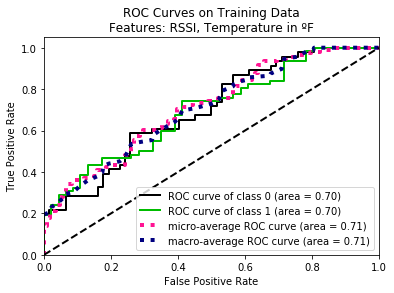

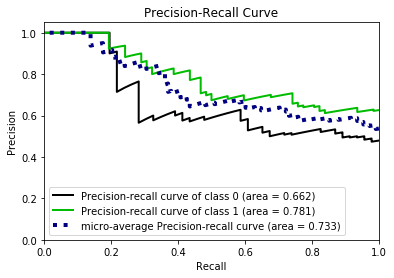

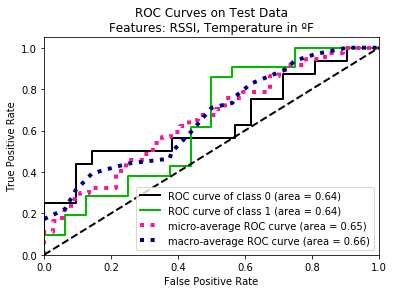

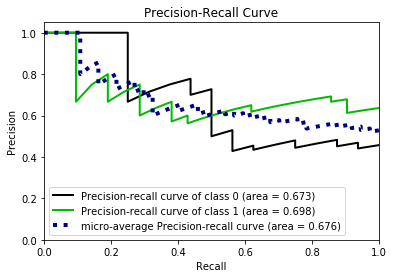

In [9]:
# Predicts if Pis were TCTL using x's features and theta
def prob(x):
    prob_1 = sigmoid(np.dot(x, theta))
    prob_0 = np.ones(len(x)) - prob_1
    return prob_1, prob_0

import scikitplot as skplt
y_probas_1 = np.reshape(prob(X_train)[0], (len(X_train), 1)) # Probability of training example == 1
y_probas_0 = np.reshape(prob(X_train)[1], (len(X_train), 1)) # Probability of training example == 0
y_probas = np.concatenate((y_probas_0, y_probas_1), axis=1)
skplt.metrics.plot_roc(np.ravel(y_train), y_probas, 
                       title='ROC Curves on Training Data\nFeatures: RSSI, Temperature in ºF') # Plot ROC Curve
skplt.metrics.plot_precision_recall(np.ravel(y_train), y_probas)
plt.show()

y_probas_1 = np.reshape(prob(X_test)[0], (len(X_test), 1)) # Probability of test example == 1
y_probas_0 = np.reshape(prob(X_test)[1], (len(X_test), 1)) # Probability of test example == 0
y_probas = np.concatenate((y_probas_0, y_probas_1), axis=1)
skplt.metrics.plot_roc(np.ravel(y_test), y_probas, 
                       title='ROC Curves on Test Data\nFeatures: RSSI, Temperature in ºF') # Plot ROC Curve
skplt.metrics.plot_precision_recall(np.ravel(y_test), y_probas)
plt.show()

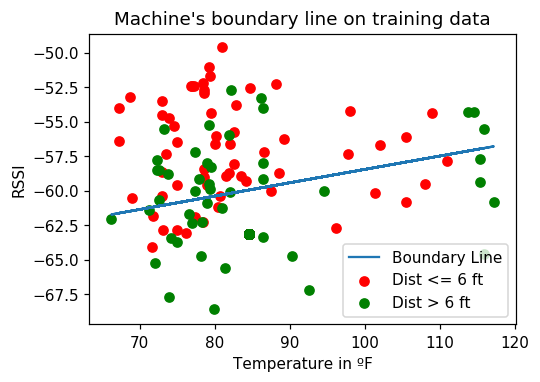

In [10]:
pos = np.nonzero(y_train == 1) # get indices where y_train == 1
neg = np.nonzero(y_train == 0) # get indices where y_train == 0
plt.figure(figsize=(5, 3.5), dpi=110)
plt.scatter(X_train[pos, 1], X_train[pos, 2], color='r', label='Dist <= 6 ft') # plot positive (1) data in red 
plt.scatter(X_train[neg, 1], X_train[neg, 2], color='g', label='Dist > 6 ft') # plot negative (0) data in red 

h = X_train[:, 1] # Temperature
# Equation for Boundary Line
# theta[0] + theta[1] * Temperature + theta[2] * RSSI == 0 
y = (h * -theta[1] - theta[0]) / theta[2] # Solve for RSSI. Stored in variable y

plt.plot(X_train[:, 1], y, label='Boundary Line') # Plot boundary line
plt.xlabel('Temperature in ºF')
plt.ylabel('RSSI')
plt.title("Machine's boundary line on training data")
plt.legend()
plt.show()

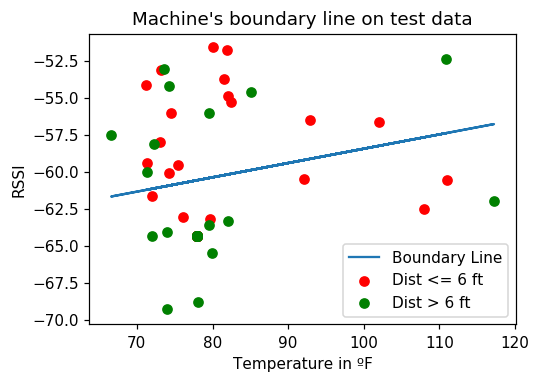

In [11]:
pos = np.nonzero(y_test == 1) # get indices where y_train == 1
neg = np.nonzero(y_test == 0) # get indices where y_train == 0
plt.figure(figsize=(5, 3.5), dpi=110)
plt.scatter(X_test[pos, 1], X_test[pos, 2], color='r', label='Dist <= 6 ft') # plot positive (1) data in red 
plt.scatter(X_test[neg, 1], X_test[neg, 2], color='g', label='Dist > 6 ft') # plot negative (0) data in red 
h = X_test[:, 1]
y = (h * -theta[1] - theta[0]) / theta[2]
plt.plot(X_test[:, 1], y, label='Boundary Line')
plt.xlabel('Temperature in ºF')
plt.ylabel('RSSI')
plt.title("Machine's boundary line on test data")
plt.legend()
plt.show()